In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.rc = {'figure.figsize': (10,6)}
%matplotlib inline

## Multi-domain mesh from simulated data

This notebook demonstrates an example using [tetgen](https://wias-berlin.de/software/tetgen/) as the tetrahedralizer starting from a data volume.

Tetgen file formats:
http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual006.html#ff_poly

In [2]:
import numpy as np
from nanomesh import Image

### Generate data

The cell below generates a data volume with feature blobs. It consists of two domains, 1 for the *bulk* features, and 0 for the background.

If you want to use your own data, any numpy array can be passed to a [`Image`](https://nanomesh.readthedocs.io/en/latest/nanomesh.volume.html#nanomesh.volume.Volume) object. Data stored as `.npy` can be loaded using `Image.load()`.

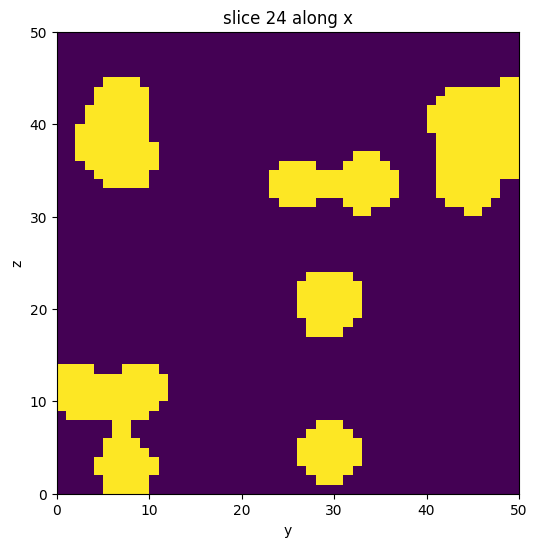

interactive(children=(IntSlider(value=24, description='index', max=49), RadioButtons(description='along', opti…

In [3]:
from nanomesh.data import binary_blobs3d

data = binary_blobs3d(seed=42)

vol = Image(data)
vol.show_slice()

### Meshing

Mesh generation consists of two steps.

1. Generate the contour mesh
2. Generate the volume envelope

The contour mesh is the surface separating the domains in the data. In this case, the 1's and 0's, so the contour level does not need to be defined. The surface mesh is completed by wrapping the entire data volume in an envelope. This makes sure that the mesh (including any domain regions) is watertight, which is a requirement for generating a tetrahedral volume mesh.

In [4]:
from nanomesh import Mesher

mesher = Mesher(vol)
mesher.generate_contour()

To plot the surface mesh:

(Use `.plot_itk()` for an interactive view)

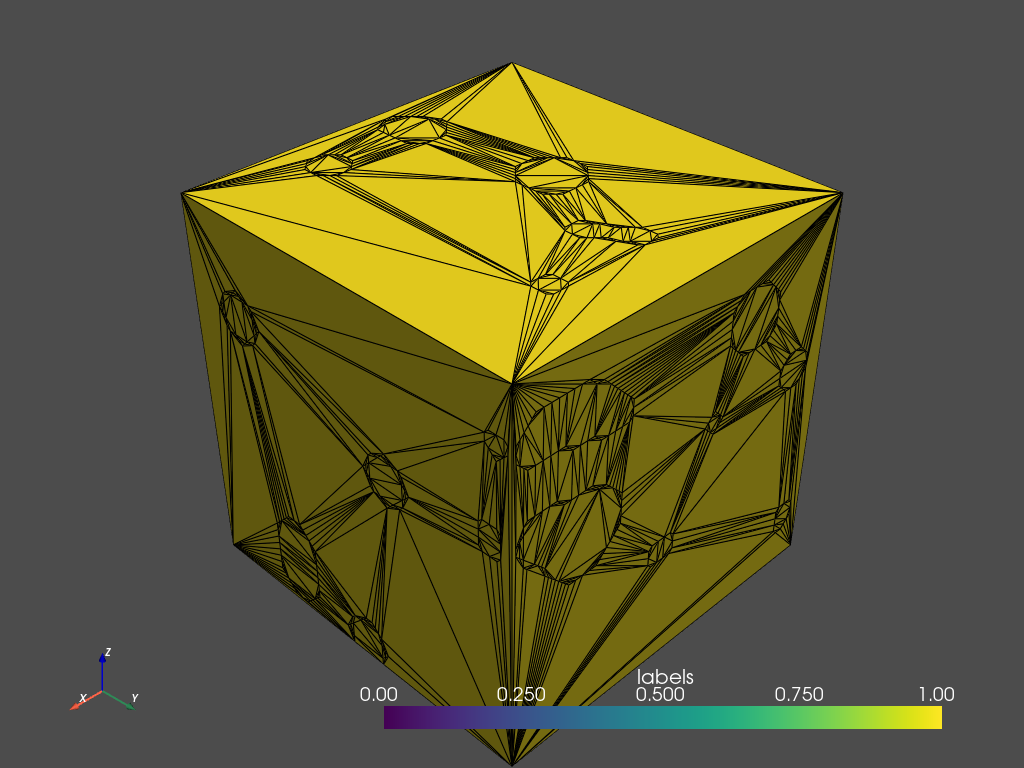

In [5]:
mesher.contour.plot_pyvista(jupyter_backend='static', show_edges=True)

### Generating a tetrahedral volume mesh

The volume mesh is generated using the `.tetrahedralize` method. This returns a tetrahedral mesh. Each domain, separated by the contour mesh defined above, is assigned a value.

The options used below:

- `-A`: Assigns attributes to tetrahedra in different regions.
- `-p`: Tetrahedralizes a piecewise linear complex (PLC).
- `-q`: Refines mesh (to improve mesh quality).
- `-a`: Applies a maximum tetrahedron volume constraint.

Don't make `-a` too small, or the algorithm will take a very long time to complete. If this parameter is left out, the triangles will keep growing without limit.

The region attributes are stored in the `tetgenRef` parameter.

Available options: http://wias-berlin.de/software/tetgen/1.5/doc/manual/manual005.html

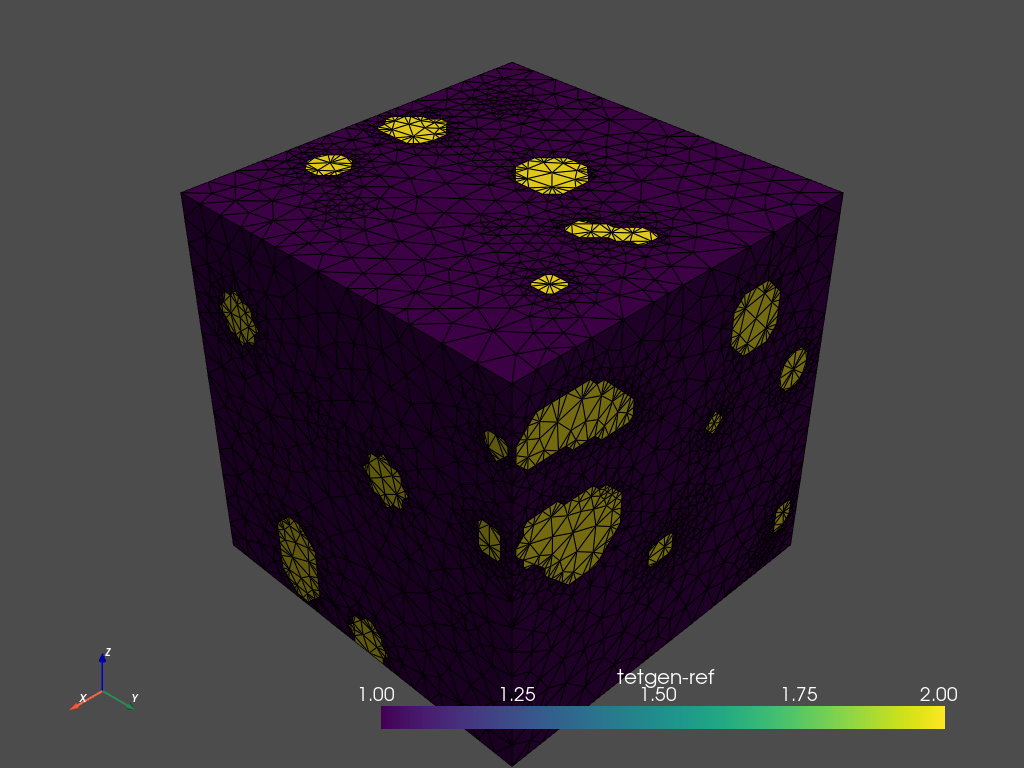

In [6]:
tetras = mesher.tetrahedralize(opts='-pAq -a10')
tetras.plot_pyvista(jupyter_backend='static',
                    show_edges=True)  # Use .plot_itk() for an interactive view

By default, the region attributes are assigned automatically by `tetgen`. Region markers assign attributes to tetrahedra in different regions. After tetrahedralization, the region markers will 'flood' the regions up to the defined boundaries. The elements of the resulting mesh are marked according to the region they belong to (`tetras.cell_data['tetgenRef']`.

It is possible to set your own attributes. The label corresponds to the attribute, and the value must be a point inside the region. The constraint can be used to set the maximum size of the triangles in combination with the `-a` parameter.

The next cell shows how you can update the region markers for the contour.

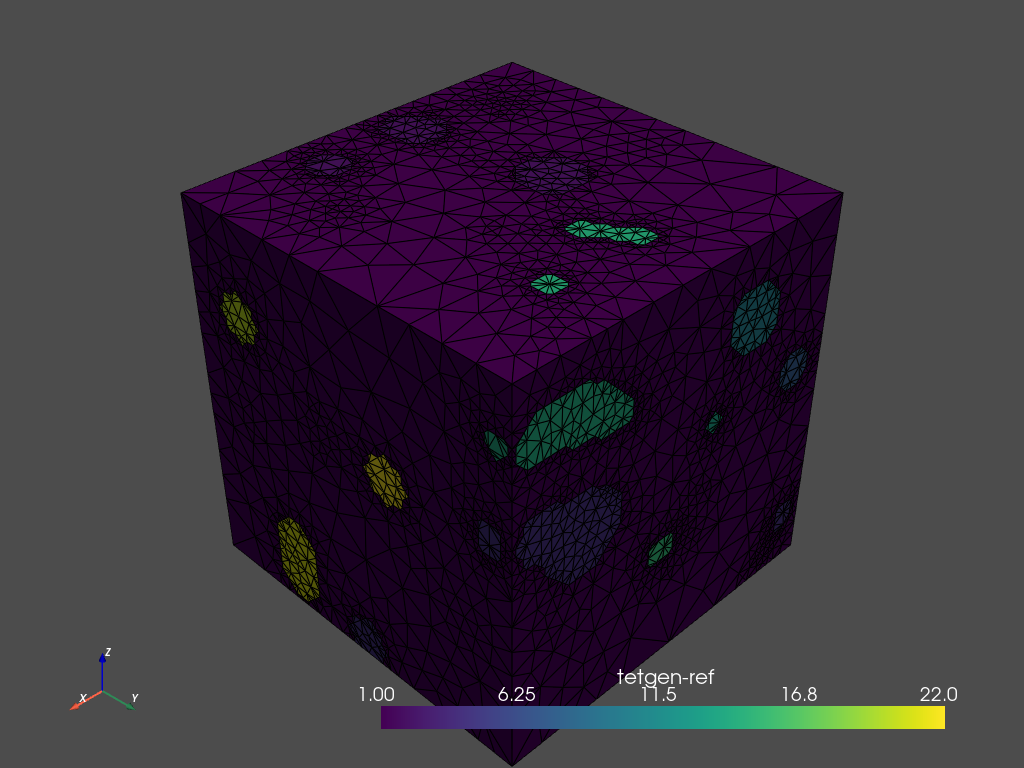

In [7]:
for i, region_marker in enumerate(mesher.contour.region_markers):
    if region_marker.name == 'background':
        region_marker.constraint = 100
    else:
        region_marker.constraint = 1
        region_marker.label = i + 1
        region_marker.name = f'feature{i+1}'

mesh = mesher.tetrahedralize(opts='-pAq -a')

# Use .plot_itk() for an interactive view
mesh.plot_pyvista(jupyter_backend='static', show_edges=True)

In [8]:
tetra_mesh = mesh.get('tetra')

for marker in mesher.contour.region_markers:
    num = np.sum(tetra_mesh.cell_data['tetgen-ref'] == marker.label)
    print(f'{num} tetrahedra with attribute `{marker}`')

112540 tetrahedra with attribute `RegionMarker(label=1, point=(11, 35, 24), name='background', constraint=100)`
20654 tetrahedra with attribute `RegionMarker(label=2, point=(19, 18, 40), name='feature2', constraint=1)`
576 tetrahedra with attribute `RegionMarker(label=3, point=(2, 15, 42), name='feature3', constraint=1)`
36897 tetrahedra with attribute `RegionMarker(label=4, point=(24, 14, 19), name='feature4', constraint=1)`
0 tetrahedra with attribute `RegionMarker(label=5, point=(5, 18, 16), name='feature5', constraint=1)`
1400 tetrahedra with attribute `RegionMarker(label=6, point=(4, 32, 27), name='feature6', constraint=1)`
577 tetrahedra with attribute `RegionMarker(label=7, point=(5, 47, 29), name='feature7', constraint=1)`
679 tetrahedra with attribute `RegionMarker(label=8, point=(7, 27, 43), name='feature8', constraint=1)`
671 tetrahedra with attribute `RegionMarker(label=9, point=(9, 41, 19), name='feature9', constraint=1)`
826 tetrahedra with attribute `RegionMarker(label=1